In [1]:
import re
import sys
import io
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Synthetic Data Generation

In [2]:
def Lorentz_System(state, sigma, rho, beta):
    x, y, z = state
    x_dot = sigma*(y-x)
    y_dot = x*(rho-z) - y
    z_dot = x*y - beta*z

    return np.array([x_dot, y_dot, z_dot])

### Runga Kutta

In [3]:
def rk4(state, dt, sigma, rho, beta):
    k1 = Lorentz_System(state, sigma, rho, beta)
    k2 = Lorentz_System(state + 0.5 * dt * k1, sigma, rho, beta)
    k3 = Lorentz_System(state + 0.5 * dt * k2, sigma, rho, beta)
    k4 = Lorentz_System(state + dt * k3, sigma, rho, beta)

    return state + (dt*((k1 + 2*k2 + 2*k3 + k4)/6.0))
    

Now, let's visualize the Lorenz attractor using N = 50,000

In [4]:
dt = 0.01
N = 50000
sigma, rho, beta = 10.0, 28.0, 8.0/3.0
x0, y0, z0 = 1.0, 1.0, 1.0
state = np.array([x0, y0, z0])

trajectory = np.empty((N+1, 3))
trajectory[0] = state

for i in range(1, N+1):
    state = rk4(state, dt, sigma, rho, beta)
    trajectory[i] = state

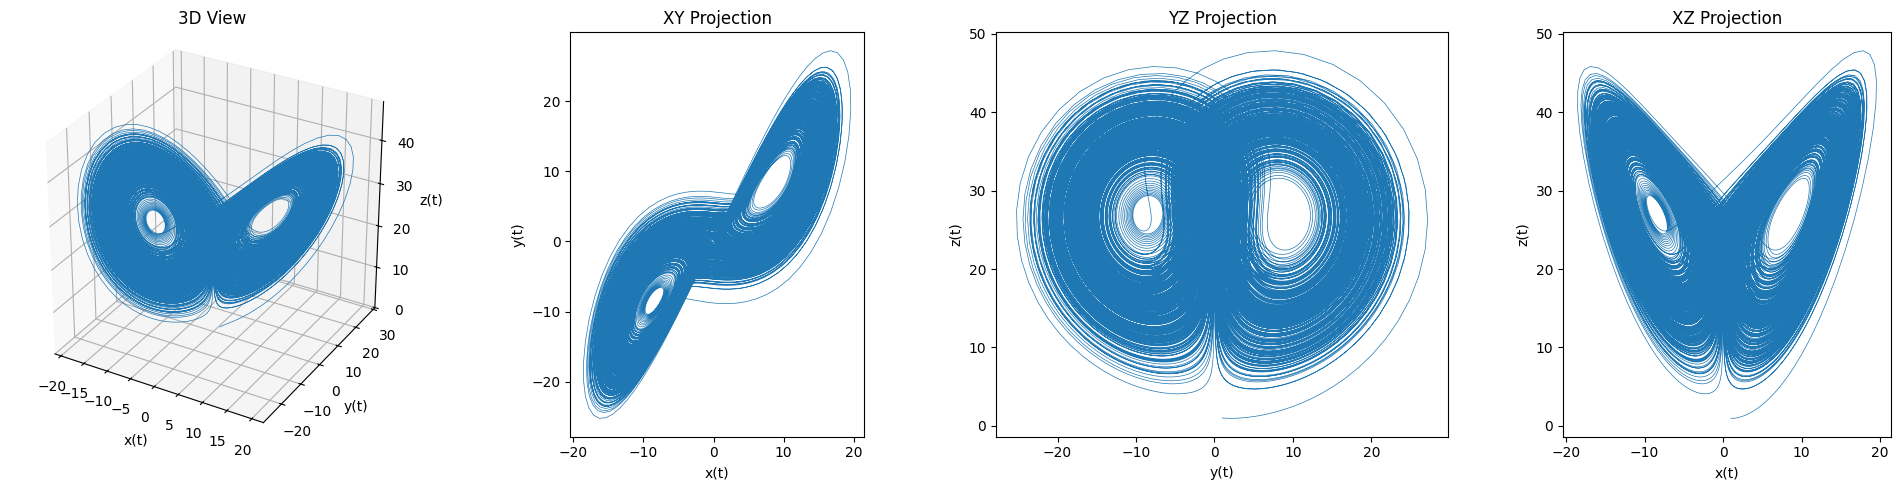

In [5]:
# Subsample trajectory to plot fewer points
thin = trajectory[::1]

fig = plt.figure(figsize=(20, 5))

# 3D
ax0 = fig.add_subplot(1, 4, 1, projection='3d')
ax0.plot(thin[:, 0], thin[:, 1], thin[:, 2], lw=0.5)
ax0.set_xlabel('x(t)'); ax0.set_ylabel('y(t)'); ax0.set_zlabel('z(t)')
ax0.set_title('3D View')
ax0.set_box_aspect((1,1,1))  # equal aspect in 3D

# XY
ax1 = fig.add_subplot(1, 4, 2)
ax1.plot(thin[:, 0], thin[:, 1], lw=0.5)
ax1.set_xlabel('x(t)'); ax1.set_ylabel('y(t)')
ax1.set_title('XY Projection')
ax1.set_aspect('equal', 'box')

# YZ
ax2 = fig.add_subplot(1, 4, 3)
ax2.plot(thin[:, 1], thin[:, 2], lw=0.5)
ax2.set_xlabel('y(t)'); ax2.set_ylabel('z(t)')
ax2.set_title('YZ Projection')
ax2.set_aspect('equal', 'box')

# XZ
ax3 = fig.add_subplot(1, 4, 4)
ax3.plot(thin[:, 0], thin[:, 2], lw=0.5)
ax3.set_xlabel('x(t)'); ax3.set_ylabel('z(t)')
ax3.set_title('XZ Projection')
ax3.set_aspect('equal', 'box')

plt.tight_layout()

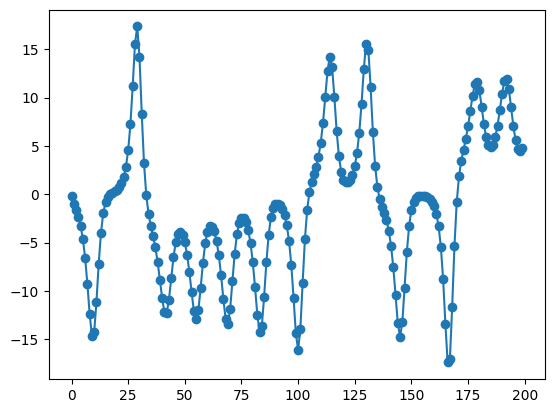

In [6]:
plt.plot(trajectory[-1000::5,0], 'o-')

In [7]:
print("First point of full trajectory:", trajectory[0])
print("Second point of full trajectory:", trajectory[1])
print("Third point of full trajectory:", trajectory[2])


First point of full trajectory: [1. 1. 1.]
Second point of full trajectory: [1.01256719 1.2599178  0.98489097]
Third point of full trajectory: [1.04882371 1.52399713 0.97311422]


# Feed Forward Neural Network

In [8]:
def make_windows(trajectory, window_size, horizon = 1):
    # horizon is the number of steps ahead to predict

    N = trajectory.shape[0]
    X, y = [], []

    for i in range(N - window_size - horizon + 1):
        X.append((trajectory[i : i + window_size]).flatten())
        y.append((trajectory[i + window_size : i + window_size + horizon]).flatten())

    return np.array(X), np.array(y)

# Neural Network Class

In [9]:
class NeuralNetwork:
    def __init__(self, input_size = 64, hidden_size = 30, output_size = 10, learning_rate = 1e-3, epochs = 1000):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # Weights & bias initialization with small random values
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01  
        self.b1 = np.zeros((1, hidden_size))                       
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01 
        self.b2 = np.zeros((1, output_size))                       #

    # ReLU activation function
    def ReLU(self, x):
        return np.maximum(0, x)

    # Derivative of the ReLU function
    def ReLU_deriv(self, x):
        return np.where(x > 0, 1, 0)

    # Linear Activation Function
    def Linear(self, x):
        return x

    def Linear_deriv(self, x):
        return np.ones_like(x)

    # Forward propagation: computes the activations for the hidden and output layers
    def forward_propagation(self, x):
        # Hidden layer
        self.z1 = x @ self.W1 + self.b1
        self.a1 = self.ReLU(self.z1)
    
        # Output layer
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.Linear(self.z2)
        
        return self.a2

    # Compute the cost using Mean Squared Error
    def compute_cost(self, y_pred, y_true):
        return np.mean((y_pred - y_true)**2)

    # Back propagation: computes gradients for updating weights and biases
    def back_propagation(self, x, y):       
        m = y.shape[0]
    
        # Compute error at output layer
        error2 = 2 * (self.a2 - y) * self.Linear_deriv(self.z2)

        # Compute gradients for weights and biases for the output layer
        grad_W2 = (self.a1.T @ error2) / m
        grad_b2 = np.sum(error2, axis = 0, keepdims = True) / m

        # Backpropagate the error to the hidden layer
        error1 = (error2 @ self.W2.T) * self.ReLU_deriv(self.z1)

        # Compute gradients for weights and biases for the hidden layer
        grad_W1 = (x.T @ error1) / m
        grad_b1 = np.sum(error1, axis = 0, keepdims = True) / m

        return grad_W1, grad_b1, grad_W2, grad_b2

    # Update the network parameters (weights and biases) using the computed gradients
    def update_parameters(self, grad_W1, grad_b1, grad_W2, grad_b2):
        self.W2 = self.W2 - (self.learning_rate * grad_W2)
        self.b2 = self.b2 - (self.learning_rate * grad_b2)
        self.W1 = self.W1 - (self.learning_rate * grad_W1)
        self.b1 = self.b1 - (self.learning_rate * grad_b1)

    # Train the neural network by iterating over epochs
    def train(self, x, y, optimizer='sgd'):
        optimizer = optimizer.lower()
        
        if optimizer not in ('sgd', 'adam'):
            raise ValueError("Optimizer must be 'sgd' or 'adam'")

        # Adam hyperparameters
        if optimizer == 'adam':
            beta1, beta2 = 0.9, 0.999
            eps = 1e-8
            # Initialize 1st & 2nd moment vectors
            m_W1 = np.zeros_like(self.W1); v_W1 = np.zeros_like(self.W1)
            m_b1 = np.zeros_like(self.b1); v_b1 = np.zeros_like(self.b1)
            m_W2 = np.zeros_like(self.W2); v_W2 = np.zeros_like(self.W2)
            m_b2 = np.zeros_like(self.b2); v_b2 = np.zeros_like(self.b2)

        for epoch in range(1, self.epochs + 1):
            # Perform forward propagation to get outputs
            Y_pred = self.forward_propagation(x)

            # Compute gradients via back propagation
            grad_W1, grad_b1, grad_W2, grad_b2 = self.back_propagation(x, y)

            if optimizer == 'sgd':
                # Update network parameters with the gradients using Standard SGD
                self.update_parameters(grad_W1, grad_b1, grad_W2, grad_b2)

            else:
                # Adam updates
                m_W1 = beta1 * m_W1 + (1 - beta1) * grad_W1
                v_W1 = beta2 * v_W1 + (1 - beta2) * (grad_W1 ** 2)
                m_b1 = beta1 * m_b1 + (1 - beta1) * grad_b1
                v_b1 = beta2 * v_b1 + (1 - beta2) * (grad_b1 ** 2)
                m_W2 = beta1 * m_W2 + (1 - beta1) * grad_W2
                v_W2 = beta2 * v_W2 + (1 - beta2) * (grad_W2 ** 2)
                m_b2 = beta1 * m_b2 + (1 - beta1) * grad_b2
                v_b2 = beta2 * v_b2 + (1 - beta2) * (grad_b2 ** 2)

                # Bias-corrected moments
                mW1_hat = m_W1 / (1 - beta1 ** epoch)
                vW1_hat = v_W1 / (1 - beta2 ** epoch)
                mb1_hat = m_b1 / (1 - beta1 ** epoch)
                vb1_hat = v_b1 / (1 - beta2 ** epoch)
                mW2_hat = m_W2 / (1 - beta1 ** epoch)
                vW2_hat = v_W2 / (1 - beta2 ** epoch)
                mb2_hat = m_b2 / (1 - beta1 ** epoch)
                vb2_hat = v_b2 / (1 - beta2 ** epoch)

                # Update parameters
                self.W1 -= self.learning_rate * mW1_hat / (np.sqrt(vW1_hat) + eps)
                self.b1 -= self.learning_rate * mb1_hat / (np.sqrt(vb1_hat) + eps)
                self.W2 -= self.learning_rate * mW2_hat / (np.sqrt(vW2_hat) + eps)
                self.b2 -= self.learning_rate * mb2_hat / (np.sqrt(vb2_hat) + eps)

            # Every 100 epochs, compute and print the cost for monitoring convergence
            if (epoch%100 == 0):
                cost = self.compute_cost(Y_pred, y)
                print(f"Epoch {epoch}, Cost: {cost:.6f}, Optimizer: {optimizer.upper()}")

    # Predict class labels for input data
    def predict(self, x):
        return self.forward_propagation(x)

# Training the Neural Network

In [10]:
# Define horizons and window size dictionary for adaptive windowing
horizons=[1,2,3,5,10,20,40]
window_sizes={1:10,2:15,3:15,5:20,10:30,20:40,40:60}
direct_rmse=[]
eps=1e-8

In [11]:
best_params = {'window_size': 20, 'hidden_size': 100, 'learning_rate': 0.01, 'batch_size': 64, 'optimizer': 'adam', 'epochs': 1000}

In [12]:
for h in horizons:
    win=window_sizes[h]

    # Prepare direct forecast data
    Xh,yh=make_windows(trajectory,win,horizon=h)
    n=Xh.shape[0]; n_tr=int(0.7*n); n_va=int(0.15*n)
    Xh_tr, yh_tr = Xh[:n_tr], yh[:n_tr]
    Xh_te, yh_true = Xh[n_tr+n_va:], yh[n_tr+n_va:]

    # Normalize
    mu_X, std_X = Xh_tr.mean(0), Xh_tr.std(0)+eps
    mu_y, std_y = yh_tr.mean(0), yh_tr.std(0)+eps
    Xh_tr_n=(Xh_tr-mu_X)/std_X; yh_tr_n=(yh_tr-mu_y)/std_y
    Xh_te_n=(Xh_te-mu_X)/std_X
    
    # Initialize and train model for direct method
    model=NeuralNetwork(
        input_size=win*3,
        hidden_size=best_params['hidden_size'],
        output_size=3*h,
        learning_rate=best_params['learning_rate'],
        epochs=best_params['epochs']
    )

    print(f"\nTraining h={h}, win={win}")
    model.train(Xh_tr_n,yh_tr_n, optimizer   = best_params['optimizer']  )

    # Predict and compute RMSE on x-coordinate
    pred_norm=model.predict(Xh_te_n)
    pred=pred_norm*std_y+mu_y
    rmse=np.sqrt(np.mean((pred[:,0::3]-yh_true[:,0::3])**2))
    direct_rmse.append(rmse)
    
    print(f"h={h} RMSE_x={rmse:.4f}")


Training h=1, win=10
Epoch 100, Cost: 0.002148, Optimizer: ADAM
Epoch 200, Cost: 0.000476, Optimizer: ADAM
Epoch 300, Cost: 0.000158, Optimizer: ADAM
Epoch 400, Cost: 0.000078, Optimizer: ADAM
Epoch 500, Cost: 0.000049, Optimizer: ADAM
Epoch 600, Cost: 0.000035, Optimizer: ADAM
Epoch 700, Cost: 0.000026, Optimizer: ADAM
Epoch 800, Cost: 0.000021, Optimizer: ADAM
Epoch 900, Cost: 0.000017, Optimizer: ADAM
Epoch 1000, Cost: 0.000031, Optimizer: ADAM
h=1 RMSE_x=0.0208

Training h=2, win=15
Epoch 100, Cost: 0.001235, Optimizer: ADAM
Epoch 200, Cost: 0.000322, Optimizer: ADAM
Epoch 300, Cost: 0.000127, Optimizer: ADAM
Epoch 400, Cost: 0.000069, Optimizer: ADAM
Epoch 500, Cost: 0.000460, Optimizer: ADAM
Epoch 600, Cost: 0.000039, Optimizer: ADAM
Epoch 700, Cost: 0.000030, Optimizer: ADAM
Epoch 800, Cost: 0.000029, Optimizer: ADAM
Epoch 900, Cost: 0.000280, Optimizer: ADAM
Epoch 1000, Cost: 0.000021, Optimizer: ADAM
h=2 RMSE_x=0.0241

Training h=3, win=15
Epoch 100, Cost: 0.001798, Optimizer

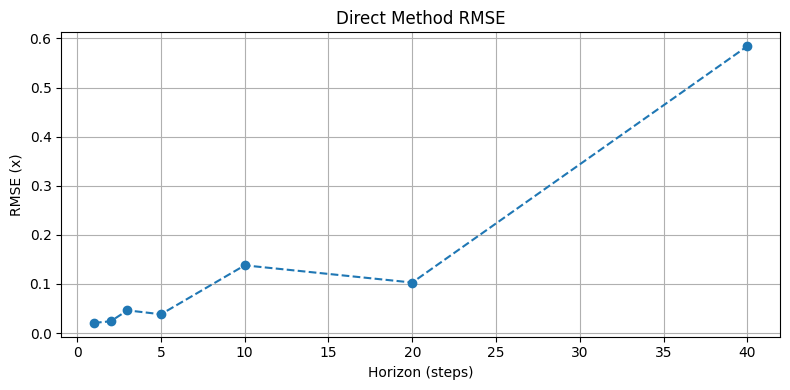

In [13]:
# Plot Direct RMSE
plt.figure(figsize=(8,4))
plt.plot(horizons,direct_rmse,'o--')
plt.xlabel('Horizon (steps)'); plt.ylabel('RMSE (x)')
plt.title('Direct Method RMSE')
plt.grid(); plt.tight_layout(); plt.show()

# Forecasting

In [22]:
# horizons and window sizes
direct_horizons = [1,2,3,5,10,20,40]
window_sizes    = {1:10,2:15,3:15,5:20,10:30,20:40,40:60}

L0 = n_train + n_val

for h in direct_horizons:
    win = window_sizes[h]
    # re-make windows & split
    Xh, yh = make_windows(trajectory, win, horizon=h)
    n = Xh.shape[0]
    n_tr = int(0.7*n)
    n_va = int(0.15*n)
    X_tr, y_tr = Xh[:n_tr], yh[:n_tr]
    # normalize using train stats
    mu_X = X_tr.mean(0,keepdims=True)
    std_X = X_tr.std(0,keepdims=True) + 1e-8
    mu_y = y_tr.mean(0,keepdims=True)
    std_y = y_tr.std(0,keepdims=True) + 1e-8
    X_tr_n = (X_tr - mu_X)/std_X
    # train direct model
    model = NeuralNetwork(
        input_size = win*3,
        hidden_size= best_params['hidden_size'],
        output_size= 3*h,
        learning_rate=best_params['learning_rate'],
        epochs=best_params['epochs']
    )
    model.train(X_tr_n, (y_tr-mu_y)/std_y, optimizer=best_params['optimizer'])

    # seed window from test-split and do one-shot direct forecast
    window = trajectory[L0:L0+win].copy()
    x_norm = (window.flatten()[None,:] - mu_X)/std_X
    y_norm = model.predict(x_norm)
    y_pred = (y_norm*std_y + mu_y).flatten()

    # true past & future
    true_past   = trajectory[L0 : L0+win]
    true_future = trajectory[L0+win : L0+win+h]

    # plot for each coord
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    t_past = np.arange(-win, 0)
    t_fut  = np.arange(0, h)

    coords = ['x','y','z']
    for col in range(3):
        # past → true future
        axes[0,col].plot(t_past, true_past[:,col], 'o-', label='True past')
        axes[0,col].plot(t_fut,  true_future[:,col], '-',  label='True future', alpha=0.6)
        axes[0,col].axvline(0, color='k', linestyle='--')
        axes[0,col].set_title(f"{coords[col].upper()}: past→future (h={h})")
        axes[0,col].set_xlabel('Rel step'); axes[0,col].set_ylabel(f'{coords[col]}(t)')

        # direct forecast vs true
        axes[1,col].plot(t_fut, true_future[:,col], '-', label='True future', alpha=0.6)
        axes[1,col].plot(t_fut, y_pred[col::3], '--', label='Direct forecast', alpha=0.8)
        axes[1,col].set_title(f"{coords[col].upper()}: forecast vs true (h={h})")
        axes[1,col].set_xlabel('Step ahead'); axes[1,col].set_ylabel(f'{coords[col]}(t)')
        axes[1,col].legend()

    fig.tight_layout()
    plt.show()

NameError: name 'n_train' is not defined

In [ ]:
iter_horizons = direct_horizons
iter_rmse = []
for h in iter_horizons:
    window = trajectory[L0:L0+best_params['window_size']].copy()
    preds = []
    for _ in range(h):
        x_norm = (window.flatten()[None,:] - Xmu)/Xstd
        y_norm = final_model.predict(x_norm)
        y_pred = (y_norm*ystd + ymu).flatten()
        preds.append(y_pred[0])
        window = np.vstack([window[1:], y_pred])
    true_x = trajectory[L0+best_params['window_size'] : L0+best_params['window_size']+h, 0]
    rmse = np.sqrt(np.mean((np.array(preds) - true_x)**2))
    iter_rmse.append(rmse)
    print(f'Horizon {h}: iterative RMSE_x = {rmse:.4f}')

plt.figure(figsize=(6,4))
plt.plot(iter_horizons, iter_rmse, 'o-', linewidth=2)
plt.xlabel('Horizon (steps)')
plt.ylabel('Iterative RMSE (x)')
plt.title('Iterative Forecast RMSE vs Horizon')
plt.grid(True)
plt.tight_layout()
plt.show()
